<a href="https://colab.research.google.com/github/alagarde-bit/Computer-Vision/blob/main/lab16_Lagarde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC 4466 Computer Vision
## Lab 16 - Transfer Learning
### 4/11/2022
### Alex Lagarde


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='15VrN2Bc-7fZd1Z4JH55H_B-o47A5ZhVW',
                                    dest_path= '/content/animals.zip',
                                    unzip=True)

In [44]:
batch_size = 32
img_height = 224
img_width = 224

# This is the folder where our images are
data_dir = 'animals'

# Tensorflow will choose some of the images as training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.15,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Tensorflow will chooose the rest of the images as validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.15,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3000 files belonging to 3 classes.
Using 2550 files for training.
Found 3000 files belonging to 3 classes.
Using 450 files for validation.
['cats', 'dogs', 'panda']


In [45]:
pretrained_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=[img_height, img_width, 3])
pretrained_model.trainable = False # no fine-tuning


model = tf.keras.Sequential([
    # convert image format from int [0,255] to the format expected by this model
    tf.keras.layers.Lambda(lambda data: tf.keras.applications.mobilenet.preprocess_input(tf.cast(data, tf.float32)), input_shape=[img_height, img_width, 3], name='preprocess'),
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(class_names), activation='softmax', name='class_prob')
])

In [46]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
    steps_per_execution=8
)
print('Each output from the flattened layer goes to each of the output neurons:', 62720 * 3 + 3)
print()

model.summary()

Each output from the flattened layer goes to each of the output neurons: 188163

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Lambda)         (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_9 (Flatten)         (None, 62720)             0         
                                                                 
 class_prob (Dense)          (None, 3)                 188163    
                                                                 
Total params: 2,446,147
Trainable params: 188,163
Non-trainable params: 2,257,984
_________________________________________________________________


In [49]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_sparse_categorical_accuracy', mode='max',
    patience=2)

epochs = 25

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [early_stopping_cb]
)

Epoch 1/25
80/80 [==============================] - 10s 128ms/step - loss: 6.2470e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.2539 - val_sparse_categorical_accuracy: 0.9711
Epoch 2/25
80/80 [==============================] - 7s 92ms/step - loss: 5.6836e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.2548 - val_sparse_categorical_accuracy: 0.9711
Epoch 3/25
80/80 [==============================] - 7s 92ms/step - loss: 5.0363e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.2556 - val_sparse_categorical_accuracy: 0.9711


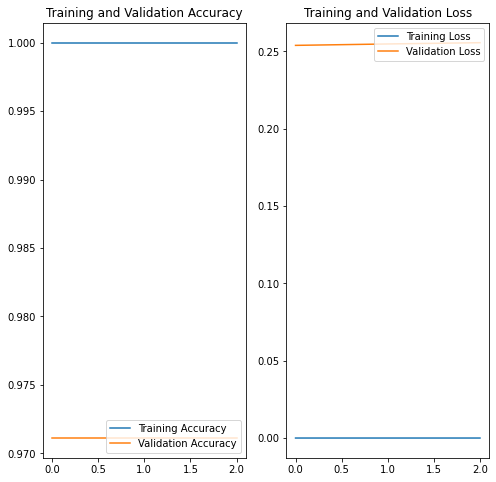

In [50]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

4. The best validation accuracy I could get was 97.83% validation accuracy

5. The lowest we can get away with is 15% validation set if we want to maintain an accuracy of around 97%